# Default Estimation and Weight of Evidence (WoE) Binning

### Default Estimator
A proxy variable is created based on RFMS formalism (Recency, Frequency, Monetary value, and Spending score) to classify customers as:

`Good credit: High RFMS scores`

`Bad credit: Low RFMS scores`
### Weight of Evidence (WoE) and Information Value (IV)
Binning based on Weight of Evidence (WoE) helps quantify the predictive power of categorical variables in relation to credit risk. This involves:

Splitting continuous variables into categories.
Calculating WoE for each bin to assess its impact on default likelihood.

In [26]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os, sys

# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
# Import load_data module
from data_loader import load_data

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE


In [12]:
# Load the data sets
df_normalized = load_data('../data/processed/extracted_features.csv')

Data successfully loaded from ../data/processed/extracted_features.csv
Dataset contains 95475 rows and 28 columns.



In [13]:
from model_training import CreditScoreRFM

# Initialize RFMS object
rfm = CreditScoreRFM(df_normalized.reset_index())

In [14]:
# Step 1: Calculate Recency, Frequency, and Monetary
rfm_df = rfm.calculate_rfm()

# Display the first five rows
rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary']].head()

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_4406,2065,119,109921.75
2,CustomerId_4683,2145,2,1000.00
3,CustomerId_988,2069,38,228727.20
5,CustomerId_1432,2154,1,2000.00
6,CustomerId_2858,2069,29,93400.00


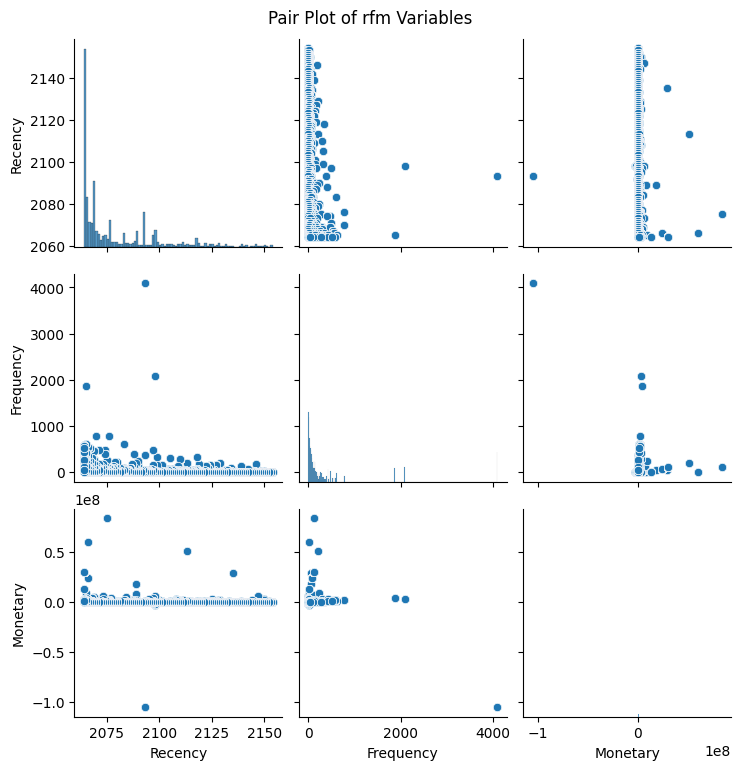

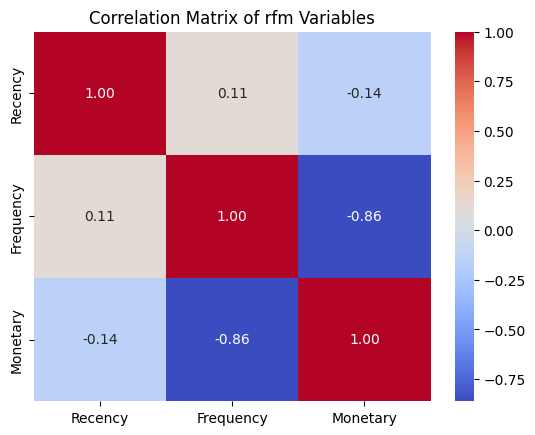

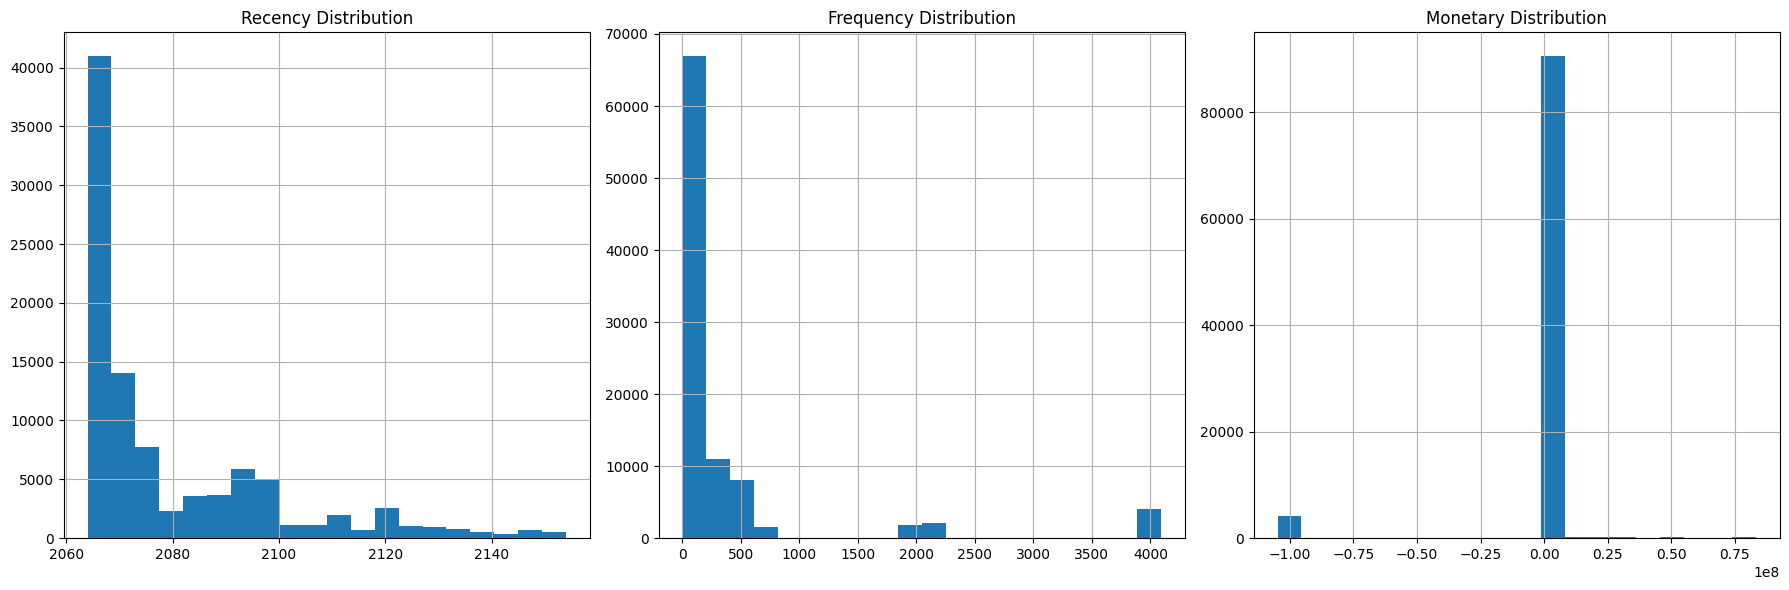

In [15]:
# visualize the RFM variables

def visualize_rfm_data():
    """
    Function to run all RFMS visualizations.
    """
    rfm.plot_pairplot()
    rfm.plot_heatmap()
    rfm. plot_histograms()
 
visualize_rfm_data()


In [16]:
# Calculate RFM scores
rfm_df_scores = rfm.calculate_rfm_scores(rfm_df)

# Assign lables
rfm.assign_label(rfm_df_scores)

# Display the updated rfms_data DataFrame
rfm_df[['CustomerId',	'Recency',	'Frequency', 'Monetary', 'RFM_Score', 'Risk_Label']].head(10)

,CustomerId,Recency,Frequency,Monetary,RFM_Score,Risk_Label
0,CustomerId_4406,2065,119,109921.75,4.00,Good
2,CustomerId_4683,2145,2,1000.00,1.00,Bad
3,CustomerId_988,2069,38,228727.20,4.00,Good
5,CustomerId_1432,2154,1,2000.00,1.00,Bad
6,CustomerId_2858,2069,29,93400.00,4.00,Good
8,CustomerId_598,2153,4,8060.00,1.90,Bad
9,CustomerId_1053,2153,7,13788.00,1.90,Bad
10,CustomerId_3052,2126,12,10700.00,2.35,Good
16,CustomerId_3105,2065,197,157448.00,4.00,Good
19,CustomerId_3507,2105,11,6350.00,2.45,Good


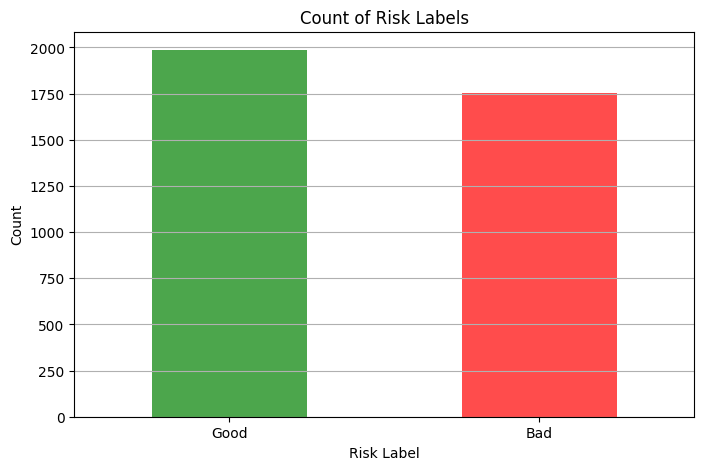

In [17]:
# Count the occurrences of each risk label
risk_counts = rfm_df['Risk_Label'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
risk_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Count of Risk Labels')
plt.xlabel('Risk Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y')

# Show the plot
plt.show()

## Weight of Evidence (WoE) Binning

In [18]:
rfm_df['RFM_bin'] = pd.qcut(rfm_df['RFM_Score'], 5, labels=False, duplicates='drop')

good_count, bad_count = rfm.calculate_counts(rfm_df)

woe_values, iv = rfm.calculate_woe(good_count, bad_count)
print(woe_values)  # Check the WoE values
print(f"Information Value (IV): {iv}")  # Print the IV


RFM_bin
0   -22.214351
1   -22.320096
2     1.431675
3    22.155806
4    21.890311
Name: Risk_Label, dtype: float64
Information Value (IV): 37.4847824754816


In [20]:
# Create a mapping Series from the WoE values
woe_mapping = pd.Series(woe_values, index=good_count.index)

# Map WoE values back to the original DataFrame
rfm_df['RFM_woe'] = rfm_df['RFM_bin'].map(woe_mapping)

# Now you have a column with WoE values in the original DataFrame
rfm_df[['RFM_Score', 'RFM_bin', 'Risk_Label', 'RFM_woe']].head(10)


,RFM_Score,RFM_bin,Risk_Label,RFM_woe
0,4.00,4,Good,21.890311
2,1.00,0,Bad,-22.214351
3,4.00,4,Good,21.890311
5,1.00,0,Bad,-22.214351
6,4.00,4,Good,21.890311
8,1.90,1,Bad,-22.320096
9,1.90,1,Bad,-22.320096
10,2.35,2,Good,1.431675
16,4.00,4,Good,21.890311
19,2.45,2,Good,1.431675


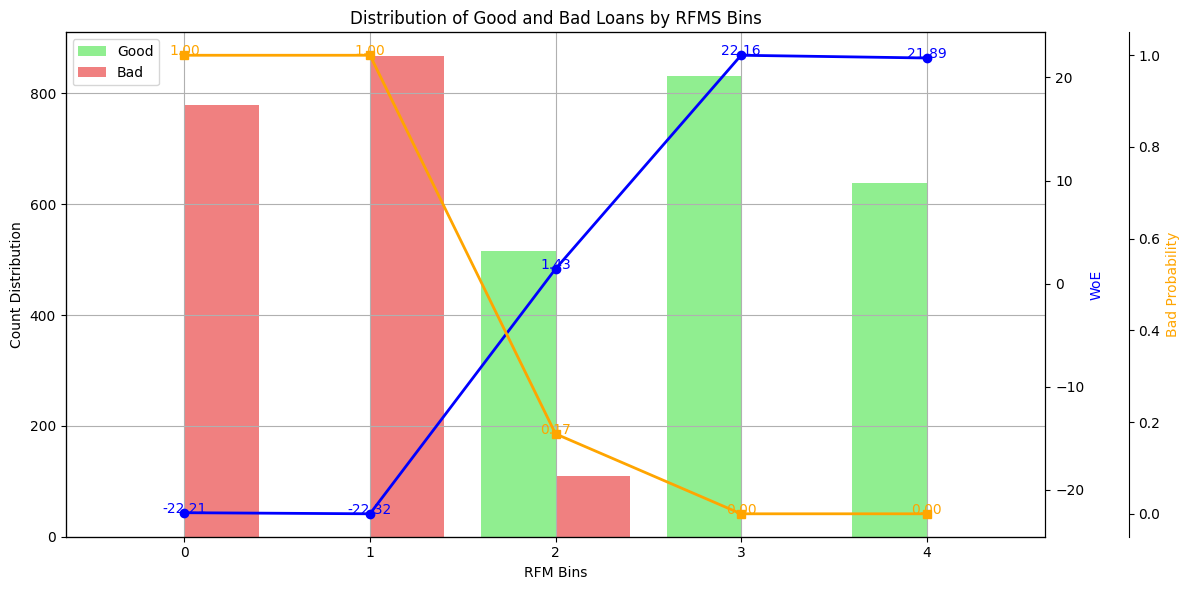

In [21]:

# Calculate Bad Probability
bad_probability = bad_count / (good_count + bad_count)

plot_data = pd.DataFrame({
    'RFM_bin': good_count.index,
    'Good_Count': good_count.values,
    'Bad_Count': bad_count.values,
    'Bad_Probability': bad_probability.values,
    'RFM_woe': rfm_df.groupby('RFM_bin')['RFM_woe'].first().values
})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Good and Bad Counts
bar_width = 0.4
index = plot_data['RFM_bin']

# Create bar plots for Good and Bad counts
bar1 = ax1.bar(index - bar_width/2, plot_data['Good_Count'], width=bar_width, label='Good', color='lightgreen')
bar2 = ax1.bar(index + bar_width/2, plot_data['Bad_Count'], width=bar_width, label='Bad', color='lightcoral')

ax1.set_xlabel('RFM Bins')
ax1.set_ylabel('Count Distribution')
ax1.set_title('Distribution of Good and Bad Loans by RFMS Bins')
ax1.legend(loc='upper left')

# Adding WoE line
ax2 = ax1.twinx()
ax2.plot(index, plot_data['RFM_woe'], color='blue', marker='o', label='WoE', linewidth=2)
ax2.set_ylabel('WoE', color='blue')

# Annotate WoE values on the line
for i, woe in enumerate(plot_data['RFM_woe']):
    ax2.text(index[i], woe, f'{woe:.2f}', color='blue', ha='center', fontsize=10)

# Adding Bad Probability
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis outwards
ax3.plot(index, plot_data['Bad_Probability'], color='orange', marker='s', label='Bad Probability', linewidth=2)
ax3.set_ylabel('Bad Probability', color='orange')

# Annotate Bad Probability values on the line
for i, prob in enumerate(plot_data['Bad_Probability']):
    ax3.text(index[i], prob, f'{prob:.2f}', color='orange', ha='center', fontsize=10)

# Show grid
ax1.grid(True)
ax1.set_xticks(index)
ax1.set_xticklabels(plot_data['RFM_bin'])
plt.tight_layout()
plt.show()

## Model Development
### Data preprocessing

In [22]:
# Merge the DataFrames
# Create a mapping dictionary
risk_label_mapping = {'Good': 1, 'Bad': 0}

# Convert Risk_Label to binary values
rfm_df['Risk_Label'] = rfm_df['Risk_Label'].map(risk_label_mapping)

rfm_data = rfm_df[['CustomerId','Recency', 'Frequency', 'Monetary', 'Risk_Label']]

# Extract unique rows
df_normalized_unique = df_normalized.drop_duplicates(subset='CustomerId', keep='first')
features = pd.merge(df_normalized_unique, rfm_data, on='CustomerId', how='left')

# Set the CustomerId to index
features.set_index('CustomerId', inplace=True)

In [23]:
# Separate the features and targets and Drop the irrelevant features
features.drop(columns=['TransactionStartTime'], inplace=True)

target = rfm_df['Risk_Label']

In [24]:
# compute the correlation matrix to assess which features have high correlations with the proxy variable.

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Get the correlation values for the target column
corr_with_target = correlation_matrix['Risk_Label'].abs()


# Select features that have correlation above the threshold (excluding the target column itself)
selected_features = corr_with_target[corr_with_target > 0.1].index.tolist()
selected_features.remove('Risk_Label')  # Exclude the target column itself

# Return the DataFrame with only the selected features
features = features[selected_features]

In [25]:
corr_with_target.sort_values(ascending=False).reset_index(name='Correlation with Risk_Label')


,index,Correlation with Risk_Label
0,Risk_Label,1.000000
1,Recency,0.355091
2,Debit_Credit_Ratio,0.327308
3,Debit_Count,0.306244
4,Frequency,0.217279
5,Transaction_Count,0.217279
6,ChannelId_ChannelId_2,0.157636
7,Transaction_Year,0.154057
8,Transaction_Month,0.139705
9,ProductCategory_financial_services,0.132283


Based on the above correlations results:
- Focus on the features with high correlations for modeling based on the threshold of 0.1 including negative correlation

The data is split into training and testing sets (e.g., 80/20 split) to ensure that model performance is evaluated on unseen data.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

In [28]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Model Selection
The following models are considered for predicting credit risk:

**Logistic Regression**: Provides probability estimates for binary outcomes.

**Decision Trees**: Simple, interpretable model for classification.

**Random Forest**: Uses multiple decision trees for better accuracy.

**Gradient Boosting Machines (GBM)**: Optimizes model performance through boosting weak learners.

#### Hyperparameter Tuning
Techniques like `Grid Search` are used to optimize hyperparameters of the models. 

Parameters such as tree depth, number of estimators, and learning rate are tuned for each model.

In [29]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 7, None]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 5, 10]},
    'Gradient Boosting': {'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__n_estimators': [50, 100, 200]}
}

# Define pipelines
pipelines = {name: Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', model)  # The model to be trained
]) for name, model in models.items()}

# Set up GridSearchCV for each model pipeline
grid_searches = {
    name: GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
    for name, pipeline in pipelines.items()
}

In [30]:
# Train each pipeline with the resampled dataset
for name, grid_search in grid_searches.items():
    grid_search.fit(X_resampled, y_resampled)
    print(f"{name} model trained with best parameters: {grid_search.best_params_}")

Logistic Regression model trained with best parameters: {'classifier__C': 100}
Decision Tree model trained with best parameters: {'classifier__max_depth': 5}
Random Forest model trained with best parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 50}
Gradient Boosting model trained with best parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}


### Model Evaluation

#### Evaluation Metrics
To assess the performance of the models, several evaluation metrics are used:

`Accuracy`: Proportion of correct predictions.

`Precision`: The ratio of correctly predicted positive observations to the total predicted positives.

`Recall`: The ratio of correctly predicted positive observations to all observations in the actual class.

`F1 Score`: Harmonic mean of Precision and Recall.

`ROC-AUC`: Area Under the Receiver Operating Characteristic curve, which measures the model’s ability to distinguish between classes.

In [31]:
# Initialize a dictionary to store performance metrics
performance_metrics = {}
y_probs = {}

for name, pipeline in grid_searches.items():
    y_pred = pipeline.predict(X_test)  # Predictions on the test set
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    y_probs[name] = y_prob  # Store probabilities for ROC curve
    # Calculate metrics
    performance_metrics[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }

    # Display the performance metrics
for model, metrics in performance_metrics.items():
    print(f"{model}: {metrics}")

Logistic Regression: {'Accuracy': 0.9118825100133512, 'Precision': np.float64(0.9510869565217391), 'Recall': np.float64(0.8793969849246231), 'F1 Score': np.float64(0.9138381201044387), 'ROC AUC': np.float64(0.9594267634468641)}
Decision Tree: {'Accuracy': 0.9265687583444593, 'Precision': np.float64(0.9698630136986301), 'Recall': np.float64(0.8894472361809045), 'F1 Score': np.float64(0.927916120576671), 'ROC AUC': np.float64(0.9651247691448698)}
Random Forest: {'Accuracy': 0.9238985313751669, 'Precision': np.float64(0.9885386819484241), 'Recall': np.float64(0.8668341708542714), 'F1 Score': np.float64(0.9236947791164659), 'ROC AUC': np.float64(0.9748636344113731)}
Gradient Boosting: {'Accuracy': 0.9252336448598131, 'Precision': np.float64(0.9672131147540983), 'Recall': np.float64(0.8894472361809045), 'F1 Score': np.float64(0.9267015706806283), 'ROC AUC': np.float64(0.9733281793583302)}


#### Model Performance
Summarize the key findings of the model evaluation, highlighting

In [32]:
# Create a DataFrame from the performance metrics
performance_df = pd.DataFrame(performance_metrics).T
performance_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.911883,0.951087,0.879397,0.913838,0.959427
Decision Tree,0.926569,0.969863,0.889447,0.927916,0.965125
Random Forest,0.923899,0.988539,0.866834,0.923695,0.974864
Gradient Boosting,0.925234,0.967213,0.889447,0.926702,0.973328


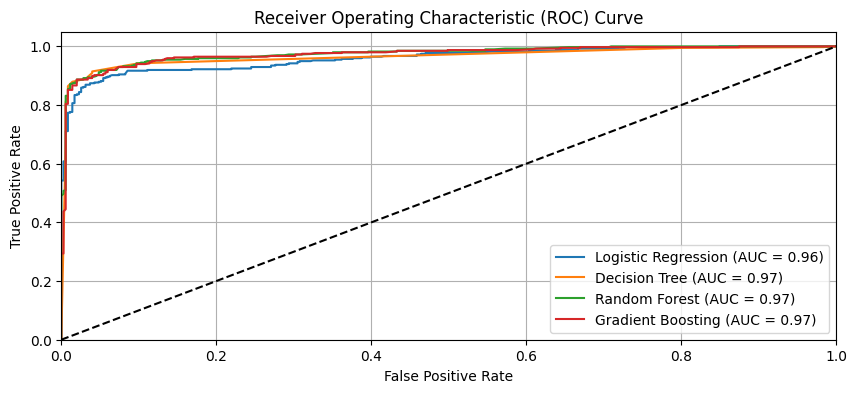

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set up the plot
plt.figure(figsize=(10, 4))

# Loop through each model's predicted probabilities
for model_name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [34]:
# Save the best model for api call
import joblib

# Assuming 'grid_search' is your GridSearchCV object and it has been run
best_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, '../api/models/best_model.pkl')

['../api/models/best_model.pkl']

In [35]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', GradientBoostingClassifier(n_estimators=200))])